# **An Interactive Data Science Tutorial**


*[Based on the Titanic competition on Kaggle](https://www.kaggle.com/c/titanic)*

*by Helge Bjorland & Stian Eide*

*January 2017*

---

## Content


 1. Business Understanding (5 min)
     * Objective
     * Description
 2. Data Understanding (15 min)
    * Import Libraries
    * Load data
    * Statistical summaries and visualisations
    * Excersises
 3. Data Preparation (5 min)
    * Missing values imputation
    * Feature Engineering
 4. Modeling (5 min)
     * Build the model
 5. Evaluation (5 min)
     * Model performance
     * Feature importance
 6. Deployment  (5 min)
     * Submit result to Kaggle leaderboard
 7. Competition (20 min)
     * Who gets the best performing model?

[*Adopted from Cross Industry Standard Process for Data Mining (CRISP-DM)*](http://www.sv-europe.com/crisp-dm-methodology/)

![CripsDM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/220px-CRISP-DM_Process_Diagram.png "Process diagram showing the relationship between the different phases of CRISP-DM")

# 1. Business Understanding

## 1.1 Objective
Predict survival on the Titanic

## 1.2 Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

**Before going further, what do you think is the most important reasons passangers survived the Titanic sinking?**

[Description from Kaggle](https://www.kaggle.com/c/titanic)

# 2. Data Understanding

## 2.1 Import Libraries
First of some preparation. We need to import python libraries containing the necessary functionality we will need. 

*Simply run the cell below by selecting it and pressing the play button.*

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2.2 Setup helper Functions
There is no need to understand this code. Just run it to simplify the code later in the tutorial.

*Simply run the cell below by selecting it and pressing the play button.*

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 2.3 Load data
Now that our packages are loaded, let's read in and take a peek at the data.

*Select the cell below and run it by pressing the play button.*

In [3]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("../input/train.csv")
test    = pd.read_csv("../input/test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


## 2.4 Statistical summaries and visualisations

To understand the data we are now going to consider some key facts about various variables including their relationship with the target variable, i.e. survival.

We start by looking at a few lines of the data

*Select the cell below and run it by pressing the play button.*

In [4]:
# Run the code to see the variables, then read the variable description below to understand them.
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


**VARIABLE DESCRIPTIONS:**

We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:


**Variable Description**

 - Survived: Survived (1) or died (0)
 - Pclass: Passenger's class
 - Name: Passenger's name
 - Sex: Passenger's sex
 - Age: Passenger's age
 - SibSp: Number of siblings/spouses aboard
 - Parch: Number of parents/children aboard
 - Ticket: Ticket number
 - Fare: Fare
 - Cabin: Cabin
 - Embarked: Port of embarkation

[More information on the Kaggle site](https://www.kaggle.com/c/titanic/data)

### 2.4.1 Next have a look at some key information about the variables
An numeric variable is one with values of integers or real numbers while a categorical variable is a variable that can take on one of a limited, and usually fixed, number of possible values, such as blood type.

Notice especially what type of variable each is, how many observations there are and some of the variable values.

An interesting observation could for example be the minimum age 0.42, do you know why this is?

*Select the cell below and run it by pressing the play button.*

In [5]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,NaN,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,NaN,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


### 2.4.2 A heat map of correlation may give us a understanding of which variables are important
*Select the cell below and run it by pressing the play button.*

In [6]:
#plot_correlation_map( titanic )

### 2.4.3 Let's further explore the relationship between the features and survival of passengers 
We start by looking at the relationship between age and survival.

*Select the cell below and run it by pressing the play button.*

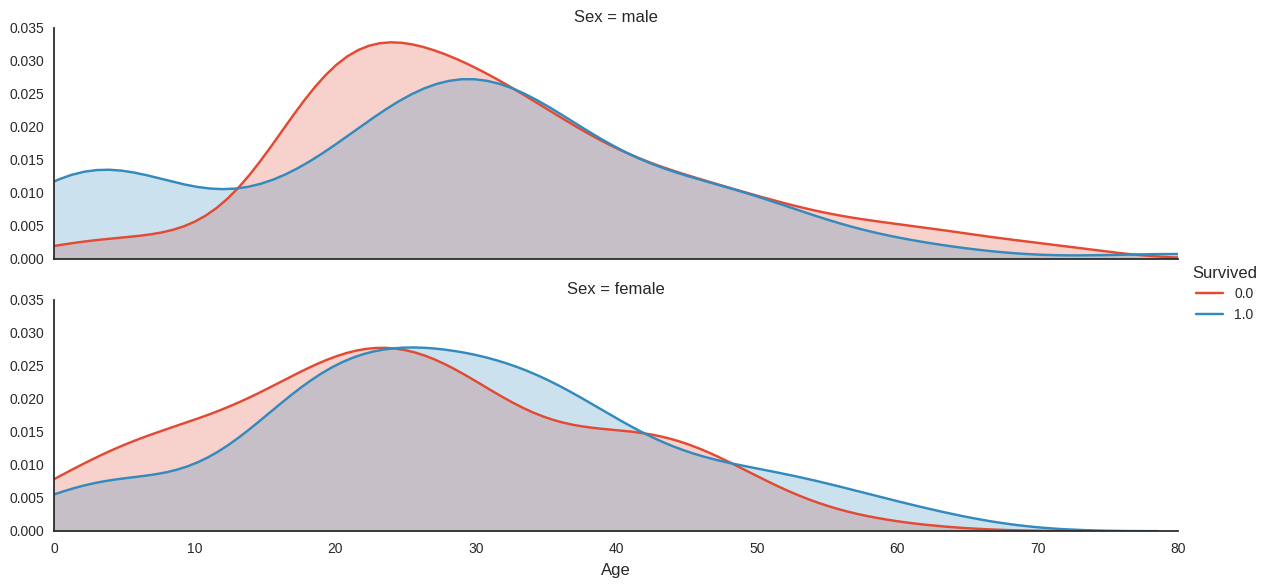

In [7]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

### 2.4.3 Excersise 1: Investigating numeric variables
It's time to get your hands dirty and do some coding! Try to plot the distributions of Fare of passangers who survived or did not survive. 

*Hint: use the code from the previous cell as a starting point.*

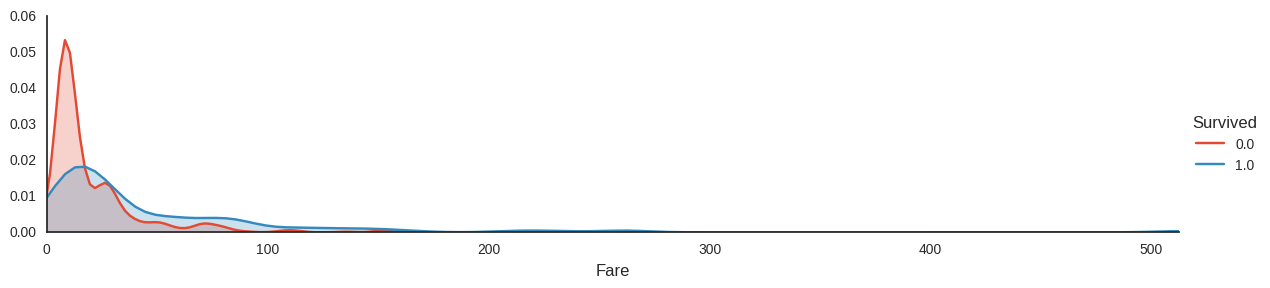

In [8]:
# Excersise 1
# Plot distributions of Fare of passangers who survived or did not survive
plot_distribution(titanic, var = 'Fare', target = 'Survived')

### 2.4.4 Embarked
We can also look at categorical variables like Embarked and their relationship with survival.

- C = Cherbourg  
- Q = Queenstown
- S = Southampton

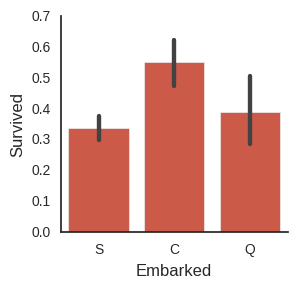

In [9]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

### 2.4.4 Excersise 2 - 5: Investigating categorical variables
Even more coding practice! Try to plot the survival rate of Sex, Pclass, SibSp and Parch below. 

*Hint: use the code from the previous cell as a starting point.*

After considering these graphs, which variables do you expect to be good predictors of survival? 

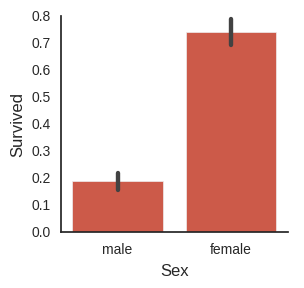

In [10]:
# Excersise 2
# Plot survival rate by Sex
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

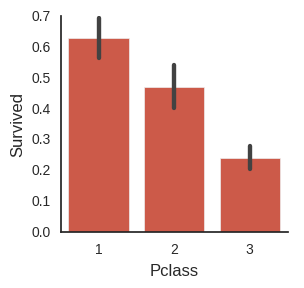

In [11]:
# Excersise 3
# Plot survival rate by Pclass
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

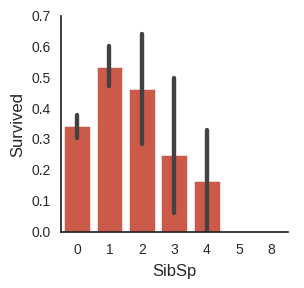

In [12]:
# Excersise 4
# Plot survival rate by SibSp
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

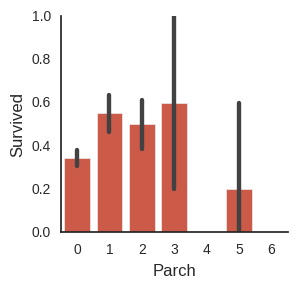

In [13]:
# Excersise 5
# Plot survival rate by Parch
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

# 3. Data Preparation

## 3.1 Categorical variables need to be transformed to numeric variables
The variables *Embarked*, *Pclass* and *Sex* are treated as categorical variables. Some of our model algorithms can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

This variable will have a value 1 if the row has a particular value and a value 0 if not. *Sex* is a dichotomy (old school gender theory) and will be encoded as one binary variable (0 or 1).

*Select the cells below and run it by pressing the play button.*

In [14]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [15]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [16]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


## 3.2 Fill missing values in variables
Most machine learning alghorims require all variables to have values in order to use it for training the model. The simplest method is to fill missing values with the average of the variable across all observations in the training set.

*Select the cells below and run it by pressing the play button.*

In [17]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


## 3.3 Feature Engineering &ndash; Creating new variables
Credit: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

### 3.3.1 Extract titles from passenger names
Titles reflect social status and may predict survival probability

*Select the cell below and run it by pressing the play button.*

In [18]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


### 3.3.2 Extract Cabin category information from the Cabin number

*Select the cell below and run it by pressing the play button.*

In [19]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.3.3 Extract ticket class from ticket number

*Select the cell below and run it by pressing the play button.*

In [20]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.3.4 Create family size and category for family size
The two variables *Parch* and *SibSp* are used to create the famiy size variable

*Select the cell below and run it by pressing the play button.*

In [21]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


## 3.4 Assemble final datasets for modelling

Split dataset by rows into test and train in order to have a holdout set to do model evaluation on. The dataset is also split by columns in a matrix (X) containing the input data and a vector (y) containing the target (or labels).

### 3.4.1 Variable selection
Select which features/variables to inculde in the dataset from the list below:

 - imputed 
 - embarked
 - pclass
 - sex
 - family
 - cabin
 - ticket

*Include the variables you would like to use in the function below seperated by comma, then run the cell*

In [22]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed , embarked , cabin , sex, family ] , axis=1 )
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,0,1,0
1,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,1,0
2,26.0,7.9250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0,0
3,35.0,53.1000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,1,0
4,35.0,8.0500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,0,0


Feature importance - selecting the optimal features in the model
We will now try to evaluate what the most important variables are for the model to make the prediction.

*Select the cell below and run it by pressing the play button.*

### 3.4.2 Create datasets
Below we will seperate the data into training and test datasets.

*Select the cell below and run it by pressing the play button.*

In [23]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 19) (623, 19) (268, 19) (623,) (268,) (418, 19)


0.985553772071


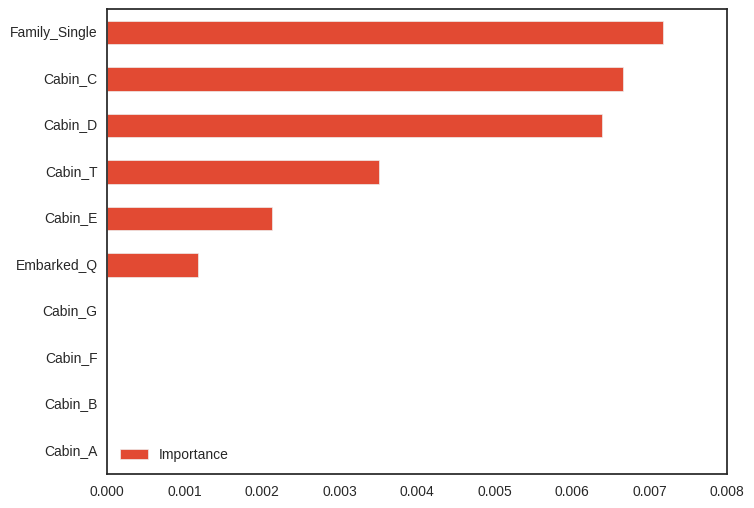

In [24]:
plot_variable_importance(train_X, train_y)

# 4. Modeling
We will now select a model we would like to try then use the training dataset to train this model and thereby check the performance of the model using the test set. 

## 4.1 Model Selection
Then there are several options to choose from when it comes to models. A good starting point is logisic regression. 

**Select ONLY model you would like to try below and run the corresponding cell by pressing the play button.**

### 4.1.1 Random Forests Model
Try a random forest model by running the cell below. 

In [25]:
model = RandomForestClassifier(n_estimators=100)

### 4.1.2 Support Vector Machines
Try a Support Vector Machines model by running the cell below. 

In [26]:
model = SVC()

### 4.1.3 Gradient Boosting Classifier
Try a Gradient Boosting Classifier model by running the cell below. 

In [27]:
model = GradientBoostingClassifier()

### 4.1.4 K-nearest neighbors
Try a k-nearest neighbors model by running the cell below. 

In [28]:
model = KNeighborsClassifier(n_neighbors = 3)

### 4.1.5 Gaussian Naive Bayes
Try a Gaussian Naive Bayes model by running the cell below. 

In [29]:
model = GaussianNB()

### 4.1.6 Logistic Regression
Try a Logistic Regression model by running the cell below. 

In [30]:
model = LogisticRegression()

## 4.2 Train the selected model
When you have selected a dataset with the features you want and a model you would like to try it is now time to train the model. After all our preparation model training is simply done with the one line below.

*Select the cell below and run it by pressing the play button.*

In [31]:
model.fit( train_X , train_y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 5. Evaluation
Now we are going to evaluate model performance and the feature importance.

## 5.1 Model performance
We can evaluate the accuracy of the model by using the validation set where we know the actual outcome. This data set have not been used for training the model, so it's completely new to the model. 

We then compare this accuracy score with the accuracy when using the model on the training data. If the difference between these are significant this is an indication of overfitting. We try to avoid this because it means the model will not generalize well to new data and is expected to perform poorly.

*Select the cell below and run it by pressing the play button.*

In [32]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.799357945425 0.847014925373


## 5.2 Feature importance - selecting the optimal features in the model
We will now try to evaluate what the most important variables are for the model to make the prediction.

*Select the cell below and run it by pressing the play button.*

In [33]:
#plot_model_var_imp(model, train_X, train_y)

### 5.2.1 Automagic
It's also possible to automatically select the optimal number of features and visualize this.

*Select the cell below and run it by pressing the play button.*

In [34]:
rfecv = RFECV( estimator = model , step = 1 , cv = StratifiedKFold( train_y , 2 ) , scoring = 'accuracy' )
rfecv.fit( train_X , train_y )

#print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
#print( "Optimal number of features : %d" % rfecv.n_features_ )

# Plot number of features VS. cross-validation scores
#plt.figure()
#plt.xlabel( "Number of features selected" )
#plt.ylabel( "Cross validation score (nb of correct classifications)" )
#plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
#plt.show()

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  1. ...,  0.  0.], n_folds=2, shuffle=False, random_state=None),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

# 6. Deployment

Deployment in this context means publishing the resulting prediction from the model to the Kaggle leaderboard. To do this do the following:

 1. select the cell below and run it by pressing the play button.
 2. Press the `Publish` button in top right corner.
 3. Select `Output` on the notebook menubar
 4. Select the result dataset and press `Submit to Competition` button

In [35]:
test_Y = model.predict( test_X )
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred.csv' , index = False )

# 7. Competition time!
It's now time for you to get your hands even dirtier and go at it all by yourself in a `challenge`! 

1. Try to the other models in step 4.1 and compare their result
    * Do this by uncommenting the code and running the cell you want to try
2. Try adding new features in step 3.4.1
    * Do this by adding them in to the function in the feature section.


**The winner is the one to get the highest score on the Kaggle leaderboard.**